## Import and main settings

In [1]:
import os
from utils_result_analysis import *


In [65]:
max_records = 10000
base_dir=os.path.abspath("../")
output_dir=f"{base_dir}/output"
data_dir = f"{base_dir}/data"
events_dir=f"{data_dir}/events"
teams_list=  ['vibro1','vibro2','vibro3','vibro4','visione1','visione2','visione3','visione4','cvhunter1', 'cvhunter2','cvhunter3', 'cvhunter4'] #teams used in the analysis
if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
sns.set_context("paper", font_scale=1.7) #rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15}

# Loading and processing data

In [3]:
#loading tasks
tasks_df = pd.read_csv(f"{data_dir}/tasks.csv")
task_list=tasks_df['name'].unique()
#loading submissions
submissions_df = pd.read_csv(f"{data_dir}/submissions.csv")

#loading all teams results (we have a csv file for each time. We read these files and create  dataframes with all team logs)
dfs = []
dfs_events = []
for f in os.listdir(events_dir):
    team_df = pd.read_csv(os.path.abspath(f"{events_dir}/{f}"))
    dfs_events.append(team_df)
    team_df = get_team_values_df(team_df, tasks_df, max_records)
    dfs.append(team_df)

df_events=pd.concat(dfs_events,axis=0) # dataframe with one row for each query and best rank info
df_results = pd.concat(dfs, axis=0) # dataframe with one row for each task-team-user
df_events=df_events[df_events['team'].isin(teams_list)]
df_results=df_results[df_results['team'].isin(teams_list)]
teams_family_list=df_events['teamFamily'].unique()
print(f" ** Teams considered in the analysis: ** {teams_list}")
print(f" ** Team Families considered in the analysis: ** {teams_family_list}")
print(f"df_events: {df_events.shape}" )
print(f"df_results: {df_results.shape}" )



 ** Teams considered in the analysis: ** ['vibro1', 'vibro2', 'vibro3', 'vibro4', 'visione1', 'visione2', 'visione3', 'visione4', 'cvhunter1', 'cvhunter2', 'cvhunter3', 'cvhunter4']
 ** Team Families considered in the analysis: ** ['cvhunter' 'vibro' 'visione']
df_events: (4361, 14)
df_results: (682, 18)


In [4]:
task_list.shape[0]

57

In [5]:
df_results.head()

,teamFamily,team,user,task,task_start,time_correct_submission,time_best_video,time_best_shot,time_best_shot_margin5,rank_video,rank_shot_margin_0,rank_shot_margin_5,time_first_appearance,rank_shot_first_appearance,time_last_appearance,rank_shot_last_appearance,time_first_appearance_video,rank_video_first_appearance
0,cvhunter,cvhunter1,1,vbse001,1.668157e+12,24.0,14.0,14.0,14.0,2.0,2.0,2.0,14.0,2.0,15.0,2.0,14.0,2.0
1,cvhunter,cvhunter1,1,vbse002,1.668158e+12,-1.0,178.0,178.0,178.0,96.0,96.0,96.0,8.0,136.0,263.0,135.0,8.0,136.0
2,cvhunter,cvhunter1,1,vbse003,1.668158e+12,87.0,35.0,35.0,35.0,33.0,33.0,33.0,9.0,48.0,35.0,33.0,9.0,46.0
3,cvhunter,cvhunter1,1,vbse004,1.668158e+12,18.0,11.0,11.0,11.0,3.0,3.0,3.0,11.0,3.0,11.0,3.0,11.0,3.0
4,cvhunter,cvhunter1,1,vbse005,1.668158e+12,13.0,9.0,9.0,9.0,2.0,2.0,2.0,9.0,2.0,10.0,2.0,9.0,2.0


In [6]:
df_events.head()

,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,teamFamily
0,vbse001,cvhunter1,1,1668157262045,13678.0,24219.0,2.0,2.0,2.0,TEXT,JointEmbedding,CLIP: A woman holding a steaming mug close to ...,{},cvhunter
1,vbse001,cvhunter1,1,1668157263040,14673.0,24219.0,2.0,2.0,2.0,TEXT,JointEmbedding,CLIP: A woman holding a steaming mug close to ...,{},cvhunter
2,vbse002,cvhunter1,1,1668157580162,8188.0,NaN,136.0,136.0,136.0,TEXT,JointEmbedding,CLIP: Viewer moving fast backwards on railway ...,{},cvhunter
3,vbse002,cvhunter1,1,1668157580949,8975.0,NaN,136.0,136.0,136.0,TEXT,JointEmbedding,CLIP: Viewer moving fast backwards on railway ...,{},cvhunter
4,vbse002,cvhunter1,1,1668157614097,42123.0,NaN,1161.0,1161.0,1161.0,IMAGE,feedbackModel,Bayes CLIP 15821:2727_16612:962_12565:4812_522...,{},cvhunter


In [7]:
submissions_df.head() #contains submission of each task

,taskName,team,teamFamily,user,task_start,task_end,timestamp,sessionID,status
0,vbse001,cvhunter3,cvhunter,3,1.668157e+12,1.668158e+12,1668157260122,d4549039-edba-4f67-be8d-49631b50e3d1,CORRECT
1,vbse001,cvhunter4,cvhunter,4,1.668157e+12,1.668158e+12,1668157265367,af025988-70ba-4e86-8b9d-3004de40a677,CORRECT
2,vbse001,vibro4,vibro,4,1.668157e+12,1.668158e+12,1668157269373,eda40d9d-2a9e-44a7-81ab-fa9a826663ea,CORRECT
3,vbse001,cvhunter1,cvhunter,1,1.668157e+12,1.668158e+12,1668157272586,a2b6d319-7da0-4278-a13b-ae553c892168,CORRECT
4,vbse001,cvhunter2,cvhunter,2,1.668157e+12,1.668158e+12,1668157278121,c08385eb-b1ec-4ed5-ba19-9441104833d0,CORRECT


## COMPUTING DRES SCORES
both using original teams and teams aggregated by 'teamFamily'

In [8]:
print(f"Computing scores for the following teams: {teams_list}")
team_scores_df=compute_team_scores(task_list, teams_list,submissions_df)
team_scores_df= team_scores_df.rename(columns={'score':'score'})

print(f"Computing scores for the following teams: {teams_family_list}")
team_aggregated_by_family_scores_df=compute_team_scores(task_list, teams_family_list,submissions_df)
team_aggregated_by_family_scores_df= team_aggregated_by_family_scores_df.rename(columns={'team': 'teamFamily','score':'score_family'})

#adding scores to the  df_resuls
df_results=pd.merge(df_results,team_scores_df,on=['team', 'task'])
df_results=pd.merge(df_results,team_aggregated_by_family_scores_df,on=['teamFamily', 'task'])

df_results

Computing scores for the following teams: ['vibro1', 'vibro2', 'vibro3', 'vibro4', 'visione1', 'visione2', 'visione3', 'visione4', 'cvhunter1', 'cvhunter2', 'cvhunter3', 'cvhunter4']
Computing scores for the following teams: ['cvhunter' 'vibro' 'visione']


,teamFamily,team,user,task,task_start,time_correct_submission,time_best_video,time_best_shot,time_best_shot_margin5,rank_video,rank_shot_margin_0,rank_shot_margin_5,time_first_appearance,rank_shot_first_appearance,time_last_appearance,rank_shot_last_appearance,time_first_appearance_video,rank_video_first_appearance,score,score_family
0,cvhunter,cvhunter1,1,vbse001,1.668157e+12,24.0,14.0,14.0,14.0,2.0,2.0,2.0,14.0,2.0,15.0,2.0,14.0,2.0,95.963594,98.040879
1,cvhunter,cvhunter2,2,vbse001,1.668157e+12,30.0,14.0,14.0,14.0,2.0,2.0,2.0,14.0,2.0,14.0,2.0,14.0,2.0,95.041116,98.040879
2,cvhunter,cvhunter3,3,vbse001,1.668157e+12,12.0,8.0,8.0,8.0,2.0,2.0,2.0,8.0,2.0,9.0,2.0,8.0,2.0,98.040879,98.040879
3,cvhunter,cvhunter4,4,vbse001,1.668157e+12,17.0,14.0,14.0,14.0,1.0,1.0,1.0,14.0,1.0,14.0,1.0,14.0,1.0,97.166733,98.040879
4,cvhunter,cvhunter1,1,vbse002,1.668158e+12,-1.0,178.0,178.0,178.0,96.0,96.0,96.0,8.0,136.0,263.0,135.0,8.0,136.0,0.000000,94.330686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,visione,visione4,4,vbse059,1.668179e+12,239.0,205.0,205.0,205.0,3.0,4.0,4.0,56.0,1815.0,227.0,4.0,6.0,1768.0,60.085699,86.896841
678,visione,visione1,1,vbse060,1.668180e+12,49.0,8.0,8.0,8.0,1.0,8.0,8.0,8.0,8.0,39.0,8.0,8.0,1.0,91.765720,82.605364
679,visione,visione2,2,vbse060,1.668180e+12,44.0,7.0,13.0,13.0,1.0,8.0,8.0,7.0,10.0,13.0,8.0,7.0,1.0,82.605364,82.605364
680,visione,visione3,3,vbse060,1.668180e+12,73.0,6.0,6.0,6.0,1.0,8.0,8.0,6.0,8.0,6.0,8.0,6.0,1.0,87.857824,82.605364


In [9]:
df_results.columns

Index(['teamFamily', 'team', 'user', 'task', 'task_start',
       'time_correct_submission', 'time_best_video', 'time_best_shot',
       'time_best_shot_margin5', 'rank_video', 'rank_shot_margin_0',
       'rank_shot_margin_5', 'time_first_appearance',
       'rank_shot_first_appearance', 'time_last_appearance',
       'rank_shot_last_appearance', 'time_first_appearance_video',
       'rank_video_first_appearance', 'score', 'score_family'],
      dtype='object')

 ## Render and save table with all the team results


In [10]:
#cosidering all distinct teams
team_time_recall_table_df=TimeRecallTable(df_results, teams_list)
team_time_recall_table_df.to_csv(f"{output_dir}/team_time_recall_table_vbse2022.csv")
print(f"Saving: {output_dir}/team_time_recall_table_vbse2022.csv")
team_time_recall_table_df

Saving: D:\Work\Dev\workspacePYTHON\PycharmProjects\VBSE-2022/output/team_time_recall_table_vbse2022.csv


task                              vbse001 vbse002 vbse003 vbse004 vbse005  \
vibro1    correct frame      rank       7       1      45       6       -   
                             time    249s    128s     76s     11s       -   
          correct video      rank       7       1       1       6       2   
                             time    249s    128s     83s     11s      8s   
          correct submission time       -    225s       -     66s     31s   
vibro2    correct frame      rank      25       1       -       6       -   
                             time     55s    132s       -      3s       -   
          correct video      rank      25       1       1       6       1   
                             time     55s    132s      8s      3s      2s   
          correct submission time     65s    146s     68s     14s     16s   
vibro3    correct frame      rank       2     338       -       6       -   
                             time     72s     63s       -     11s       -   
          correct video      rank       2     338       4       6       1   
                             time     72s     63s     10s     11s     10s   
          correct submission time     78s       -    105s     17s     23s   
vibro4    correct frame      rank      47    1178       1       6       -   
                             time      6s     95s    259s      6s       -   
          correct video      rank      47       4       1       6       1   
                             time      6s    190s     31s      6s      6s   
          correct submission time     21s    216s    263s     16s     22s   
visione1  correct frame      rank       3     719     312     686      67   
                             time     83s    265s      9s     55s      8s   
          correct video      rank       3     123     197      67       1   
                             time     83s    101s      9s     55s      8s   
          correct submission time     87s       -     75s     92s     26s   
visione2  correct frame      rank       9      61     240    2888     107   
                             time     76s    107s     41s      7s      6s   
          correct video      rank       9      21     106     229       2   
                             time     76s    107s     67s     53s      6s   
          correct submission time     84s       -    127s     70s     30s   
visione3  correct frame      rank       1       -     312    2888     106   
                             time    161s       -      7s      7s      7s   
          correct video      rank       1    8525     197     241       2   
                             time    161s      7s      7s      7s      7s   
          correct submission time    182s       -     42s     49s     16s   
visione4  correct frame      rank       1       -     438    2888     106   
                             time    170s       -      8s      7s      8s   
          correct video      rank       1     808     247     241       2   
                             time    170s    274s      8s      7s      8s   
          correct submission time    176s       -     75s     73s     20s   
cvhunter1 correct frame      rank       2      96      33       3       2   
                             time     14s    178s     35s     11s      9s   
          correct video      rank       2      96      33       3       2   
                             time     14s    178s     35s     11s      9s   
          correct submission time     24s       -     87s     18s     13s   
cvhunter2 correct frame      rank       2     136      48       3       2   
                             time     14s      9s      9s      8s     12s   
          correct video      rank       2     136      46       3       2   
                             time     14s      9s      9s      8s     12s   
          correct submission time     30s     34s     58s     14s     17s   
cvhunter3 correct frame      rank       2       2      48       3       2

In [11]:
#considering the best "user" for each team family
df_results_best_users= df_results.loc[df_results.groupby(['teamFamily', 'task'])['score'].idxmax()]
df_results_best_users=df_results_best_users.drop(['team'], axis=1).rename(columns={'teamFamily':'team'})
bestUser_time_recall_table_df=TimeRecallTable(df_results_best_users, teams_family_list)
bestUser_time_recall_table_df.to_csv(f"{output_dir}/bestUser_time_recall_table_vbse2022.csv")
print(f"Saving: {output_dir}/bestUser_time_recall_table_vbse2022.csv")
bestUser_time_recall_table_df

Saving: D:\Work\Dev\workspacePYTHON\PycharmProjects\VBSE-2022/output/bestUser_time_recall_table_vbse2022.csv


task                             vbse001 vbse002 vbse003 vbse004 vbse005  \
cvhunter correct frame      rank       2     136      48       3       2   
                            time      8s      9s      8s      8s      8s   
         correct video      rank       2     136      46       3       2   
                            time      8s      9s      8s      8s      8s   
         correct submission time     12s     34s     33s     14s     11s   
vibro    correct frame      rank      47       1       -       6       -   
                            time      6s    132s       -      3s       -   
         correct video      rank      47       1       1       6       1   
                            time      6s    132s      8s      3s      2s   
         correct submission time     21s    146s     68s     14s     16s   
visione  correct frame      rank       9     719     312    2888     106   
                            time     76s    265s      7s      7s      7s   
         correct video      rank       9     123     197     241       2   
                            time     76s    101s      7s      7s      7s   
         correct submission time     84s       -     42s     49s     16s   

task                             vbse006 vbse007 vbse008 vbse009 vbse010  ...  \
cvhunter correct frame      rank     105       6      21      12      24  ...   
                            time      9s      7s     85s      8s    103s  ...   
         correct video      rank      42       6       3      12      24  ...   
                            time      9s      7s     85s      8s    103s  ...   
         correct submission time     49s     12s    102s     14s    121s  ...   
vibro    correct frame      rank      10      27       1       -     159  ...   
                            time     12s      6s    121s       -     79s  ...   
         correct video      rank      10      27       1      99     159  ...   
                            time     12s      6s    121s     11s     79s  ...   
         correct submission time     23s     15s    127s     35s    101s  ...   
visione  correct frame      rank     643       1      27      10      60  ...   
                            time     73s      6s    260s      8s      7s  ...   
         correct video      rank     106       1      27      10      60  ...   
                            time     73s      6s    260s      8s      7s  ...   
         correct submission time    114s     10s    280s     21s     58s  ...   

task                             vbse051 vbse052 vbse053 vbse054 vbse055  \
cvhunter correct frame      rank      23      26    2404    6575       -   
                            time     64s      6s      8s    113s       -   
         correct video      rank      13      20     226    2000       5   
                            time     64s      6s      8s    113s      7s   
         correct submission time     91s     65s     34s    205s     32s   
vibro    correct frame      rank      51       -       -       -       -   
                            time      7s       -       -       -       -   
         correct video      rank      19    3150      45       1       1   
                            time      7s     17s      6s     29s      6s   
         correct submission time     17s     29s     19s     80s     48s   
visione  correct frame      rank       4      75     412       -     252   
                            time      5s      5s      8s       -     89s   
         correct video      rank       4      14      13       3       2   
                            time      5s      5s      8s     69s     89s   
         correct submission time     11s     34s     62s     96s    190s   

task                             vbse056 vbse057 vbse058 vbse059 vbse060  
cvhunter correct frame      rank       -       -      26     135      90  
                            time       -       -      5s     94s     55s  
         correct video      rank     117    

## Boxplots

In [81]:
ylabel={"rank_shot_margin_0":"best frame/shot rank", "rank_video":"best video rank", "score": "DRES Score"}

teamFamily  user
cvhunter    1       50
            2       50
            3       50
            4       50
vibro       1       40
            2       43
            3       41
            4       42
visione     1       53
            2       53
            3       50
            4       51
Name: rank_shot_margin_0, dtype: int64


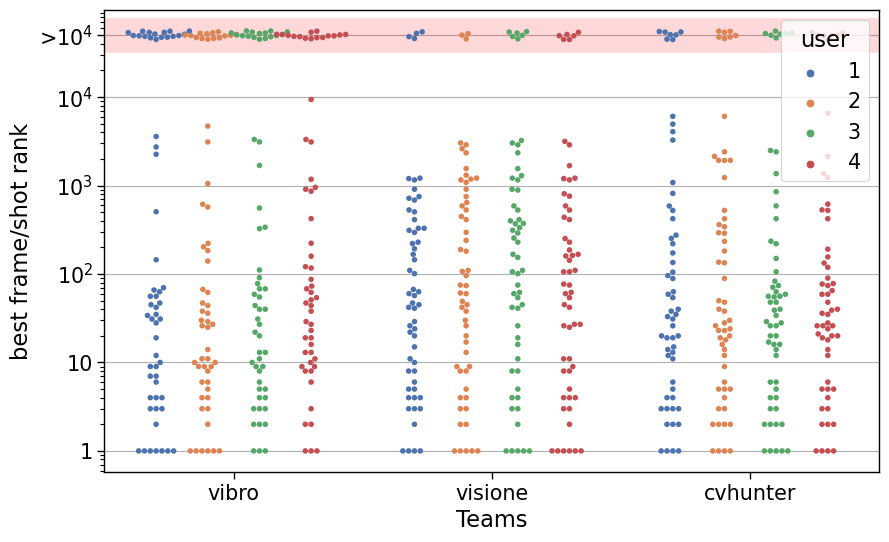

In [80]:
#x: team family, #y: rank best item

df=df_results.copy(deep=True)
max_records_plot=10000

figsize = [10, 6]
plot_column_name="rank_shot_margin_0"

view = df[df[plot_column_name] != -1].groupby(['teamFamily', 'user']).agg('count')[plot_column_name]
print(view) #checking if we can do a boxplot or if there are too many missing values

where_missing_data_is = max_records_plot * 5
#missing datapoints are set in some random lines after max_records_plot + k
df.loc[df[plot_column_name] > max_records_plot, plot_column_name]=-1

# select only some coumns of interest
df = df[[plot_column_name, "teamFamily", "user", "task"]]
df.sort_values(by=[plot_column_name])

# Initialize the figure with a logarithmic y axis
f, ax = plt.subplots(figsize=figsize)
ax.set_yscale("log")
r = list(range(0, int(math.log10(max_records_plot))))
r = r + [r[-1] + 1]
ax.set_yticks([10 ** x for x in r] + [where_missing_data_is])
ax.set_yticklabels(['1' if x == 0 else '10' if x == 1 else f'10$^{x}$' for x in r] + [f'>10$^{r[-1]}$'])
ax.yaxis.grid(True)
ax.set(xlabel="Teams")
ax.set(ylabel=ylabel[plot_column_name])

# Plots boxplots
#sns.
#sns.boxplot(x="teamFamily", hue="user", y=plot_column_name, data=df[df[plot_column_name] != -1], width=.6, palette="vlag", order=["vibro", "visione", "cvhunter"])

df.sort_values(by=[plot_column_name])
df.loc[df[plot_column_name] == -1, plot_column_name] = np.random.uniform(
        where_missing_data_is * 10 ** (-0.05),
        where_missing_data_is * 10 ** (0.05),
        len(df.loc[df[plot_column_name] == -1]))


sns.swarmplot(x="teamFamily", hue="user", y=plot_column_name, data=df,size=4, dodge=True, alpha=1,order=["vibro", "visione", "cvhunter"], palette="deep")
#sns.stripplot(x="teamFamily", hue="user", y=plot_column_name, data=df,size=5, linewidth=1, dodge=True, alpha=1, order=["vibro", "visione", "cvhunter"])
ax.axhline(y=where_missing_data_is, linewidth=25, color='r', alpha=0.15)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title="user", loc="best")  # , ncol=2,)


# sns.despine(trim=True, left=True)
plt.savefig(f'{output_dir}/kis_{plot_column_name}_boxplot_max_records{max_records_plot}.pdf', format='pdf', bbox_inches="tight")



teamFamily  user
cvhunter    1       57
            2       57
            3       56
            4       57
vibro       1       57
            2       57
            3       56
            4       57
visione     1       57
            2       56
            3       56
            4       56
Name: rank_video, dtype: int64


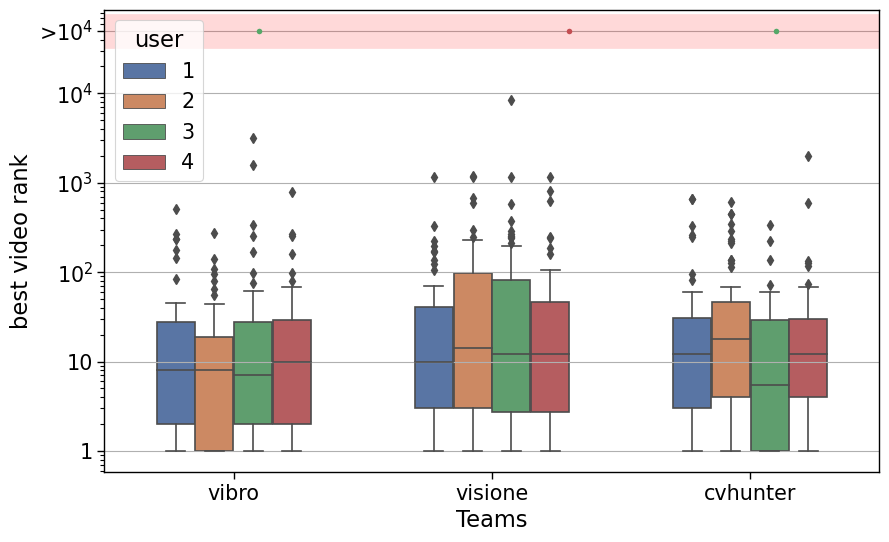

In [84]:
#x: team family, #y: rank video item
df=df_results.copy(deep=True)
max_records_plot=10000

figsize = [10, 6]
plot_column_name="rank_video"

view = df[df[plot_column_name] != -1].groupby(['teamFamily', 'user']).agg('count')[plot_column_name]
print(view) #checking if we can do a boxplot or if there are too many missing values

where_missing_data_is = max_records_plot * 5
#missing datapoints are set in some random lines after max_records_plot + k
df.loc[df[plot_column_name] > max_records_plot, plot_column_name]=-1

# select only some coumns of interest
df = df[[plot_column_name, "teamFamily", "user", "task"]]
df.sort_values(by=[plot_column_name])

# Initialize the figure with a logarithmic y axis
f, ax = plt.subplots(figsize=figsize)
ax.set_yscale("log")
r = list(range(0, int(math.log10(max_records_plot))))
r = r + [r[-1] + 1]
ax.set_yticks([10 ** x for x in r] + [where_missing_data_is])
ax.set_yticklabels(['1' if x == 0 else '10' if x == 1 else f'10$^{x}$' for x in r] + [f'>10$^{r[-1]}$'])
ax.yaxis.grid(True)


# Plots boxplots
#sns.
sns.boxplot(x="teamFamily", hue="user", y=plot_column_name, data=df[df[plot_column_name] != -1], width=.6, palette="deep", order=["vibro", "visione", "cvhunter"])

df.sort_values(by=[plot_column_name])
df.loc[df[plot_column_name] == -1, 'unknow_rank'] = where_missing_data_is


sns.swarmplot(x="teamFamily", hue="user", y='unknow_rank', data=df,size=4, dodge=True, alpha=1,order=["vibro", "visione", "cvhunter"], palette="deep")

ax.axhline(y=where_missing_data_is, linewidth=25, color='r', alpha=0.15)
ax.set(xlabel="Teams")
ax.set(ylabel="best video rank")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title="user", loc="best")  # , ncol=2,)


# sns.despine(trim=True, left=True)
plt.savefig(f'{output_dir}/kis_{plot_column_name}_boxplot_max_records{max_records_plot}.pdf', format='pdf', bbox_inches="tight")


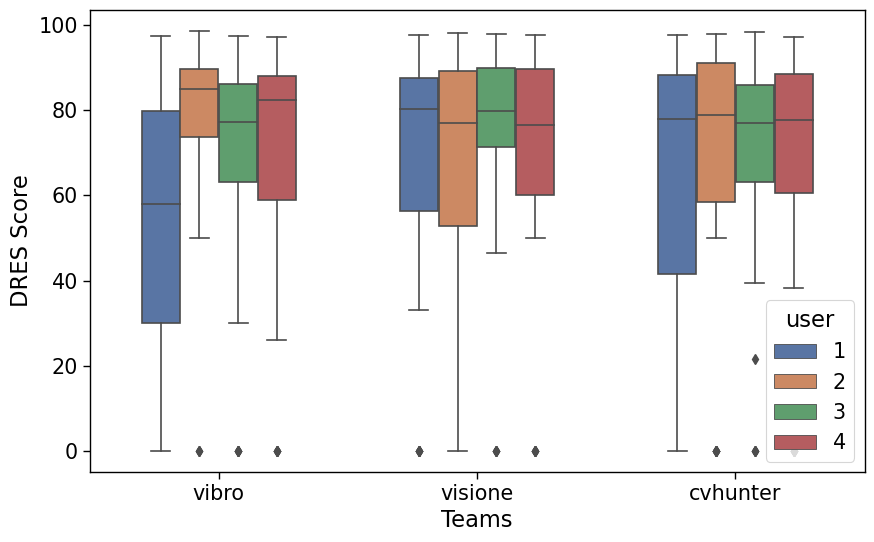

In [89]:

plot_column_name="score"
df=df_results.copy()
df = df[[plot_column_name, "teamFamily", "user", "task"]]
f, ax = plt.subplots(figsize=[10, 6])
sns.boxplot(x="teamFamily", hue="user", y=plot_column_name, data=df[df[plot_column_name] != -1], width=.6,
                            palette="deep", order=["vibro", "visione", "cvhunter"])
#sns.swarmplot(x="teamFamily", hue="user", y=plot_column_name, data=df,size=4, linewidth=.3, dodge=True, alpha=0.4)
#

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title="user", loc="lower right")  # , ncol=2,)


#ax.yaxis.grid(True)
ax.set(xlabel="Teams")
ax.set(ylabel="DRES Score")
# sns.despine(trim=True, left=True)
plt.savefig(f'{output_dir}/kis_{plot_column_name}_boxplot.pdf', format='pdf', bbox_inches="tight")

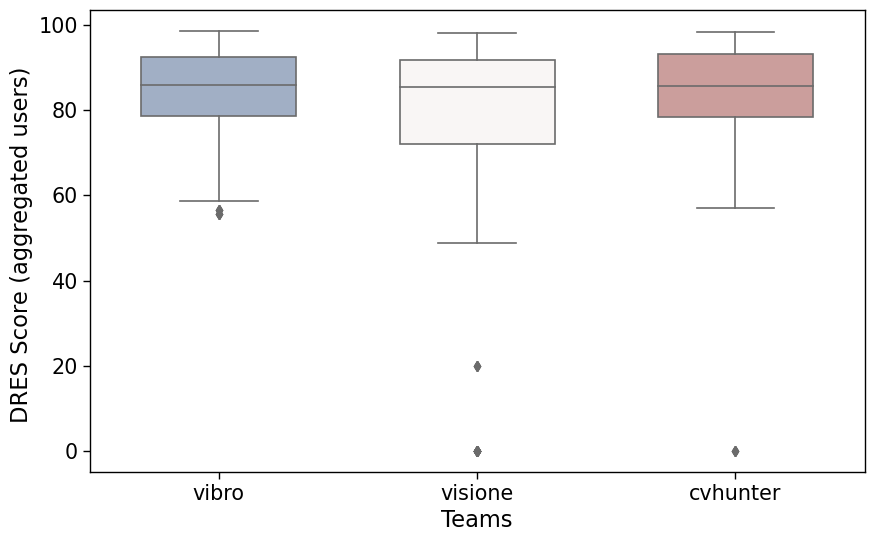

In [95]:
plot_column_name="score_family"
df=df_results.copy()
df = df[[plot_column_name, "teamFamily", "task"]]
f, ax = plt.subplots(figsize=[10, 6])
sns.boxplot(x="teamFamily", y=plot_column_name, data=df[df[plot_column_name] != -1], width=.6,
                            palette="vlag", order=["vibro", "visione", "cvhunter"])
#sns.swarmplot(x="teamFamily", hue="user", y=plot_column_name, data=df,size=4, linewidth=.3, dodge=True, alpha=0.4)
#

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[:4], labels[:4], title="Teams", loc="lower right")  # , ncol=2,)


#ax.yaxis.grid(True)
ax.set(xlabel="Teams")
ax.set(ylabel="DRES Score (aggregated users) ")
# sns.despine(trim=True, left=True)
plt.savefig(f'{output_dir}/kis_{plot_column_name}_boxplot_teamFamily.pdf', format='pdf', bbox_inches="tight")

In [87]:
df_results.columns

Index(['teamFamily', 'team', 'user', 'task', 'task_start',
       'time_correct_submission', 'time_best_video', 'time_best_shot',
       'time_best_shot_margin5', 'rank_video', 'rank_shot_margin_0',
       'rank_shot_margin_5', 'time_first_appearance',
       'rank_shot_first_appearance', 'time_last_appearance',
       'rank_shot_last_appearance', 'time_first_appearance_video',
       'rank_video_first_appearance', 'score', 'score_family'],
      dtype='object')